In [4]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random
import time
import json

from networkx.algorithms import community
from matplotlib.pyplot import figure

# my functions implemented in ./src/
from vkprint import vkprint
from crawling_algorythms import Crawler_RC,Crawler_RW,Crawler_DFS,Crawler_BFS,Crawler_MOD,Crawler_MED
from utils import import_graph,draw_graph,get_percentile, metrics_list

 Graph wikivote
b= 889 seed count= 4 methods: {'RW': <class 'crawling_algorythms.Crawler_RW'>, 'RC': <class 'crawling_algorythms.Crawler_RC'>, 'DFS': <class 'crawling_algorythms.Crawler_DFS'>, 'BFS': <class 'crawling_algorythms.Crawler_BFS'>, 'MED': <class 'crawling_algorythms.Crawler_MED'>, 'MOD': <class 'crawling_algorythms.Crawler_MOD'>} 
 percentile {'degrees': 15, 'k_cores': 7, 'eccentricity': -8, 'betweenness_centrality': 0.008199457386916775}
 wikivote 4 RW 0  it took  0 minutes
 wikivote 4 RW 1  it took  0 minutes
 wikivote 4 RW 2  it took  0 minutes
 wikivote 4 RW 3  it took  0 minutes
 wikivote 4 RC 0  it took  0 minutes
 wikivote 4 RC 1  it took  0 minutes
 wikivote 4 RC 2  it took  0 minutes
 wikivote 4 RC 3  it took  0 minutes
 wikivote 4 DFS 0  it took  0 minutes
 wikivote 4 DFS 1  it took  0 minutes
 wikivote 4 DFS 2  it took  0 minutes
 wikivote 4 DFS 3  it took  0 minutes
 wikivote 4 BFS 0  it took  0 minutes
 wikivote 4 BFS 1  it took  0 minutes
 wikivote 4 BFS 2  it 

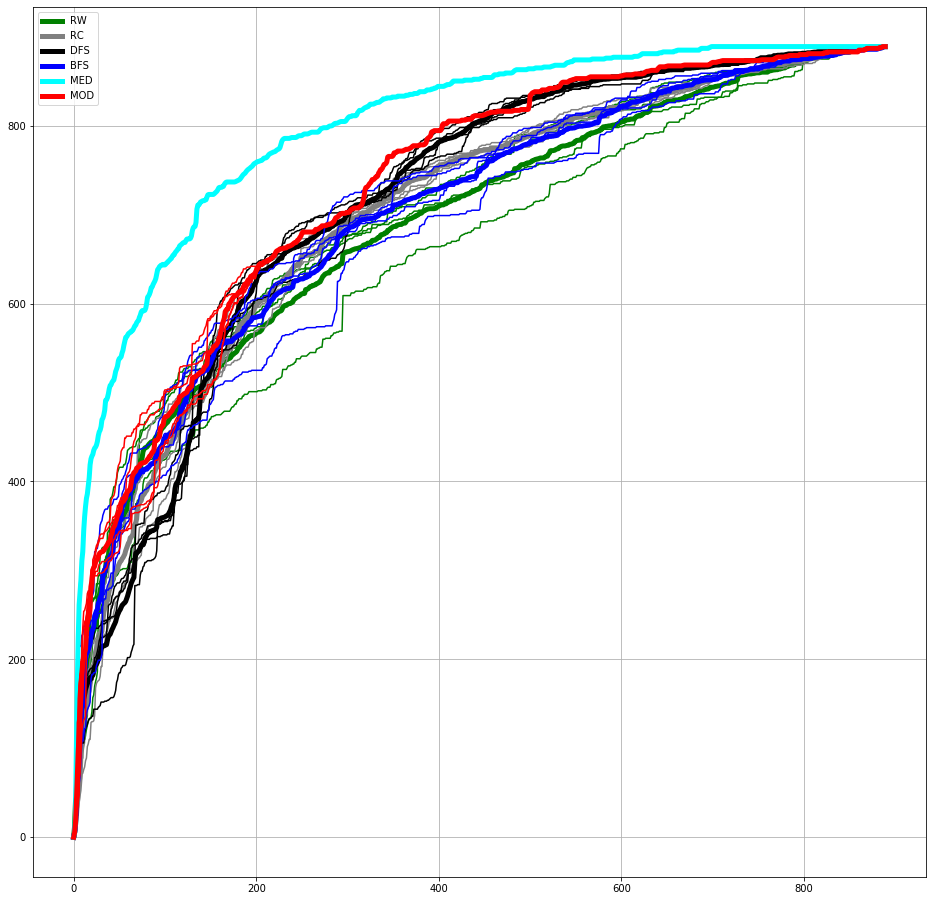

In [5]:
## макропараметры всей задачи
graph_name = 'wikivote'
methods = {'RW':Crawler_RW,'RC':Crawler_RC,'DFS':Crawler_DFS, 
               'BFS':Crawler_BFS, 'MED':Crawler_MED,'MOD':Crawler_MOD} #'AFD',
b = 121000
seed_count =4


# общие множества и вспомогательное, лучше не менять
method_color = {'AFD':'pink','RC':'grey','RW':'green','DFS':'black', 'BFS':'blue', 'MED':'cyan','MOD':'red'}
graph_name_list = ['importing',  'dblp2010',  'github','wikivote','DCAM','hamsterster','gnutella']  #'slashdot',
linestiles = [':', '--', '-.','--']*seed_count


# сама программа
t00 = time.time()
Graph = import_graph(graph_name)
b = min(Graph.number_of_nodes(),b)
percentile, percentile_set = get_percentile(Graph,graph_name,10) # берём топ 10 процентов вершин
nx.write_gml(Graph, "../data/Graphs/"+ graph_name +'_BIG.graph')
vkprint("Graph "+graph_name+"\nb=",b,"seed count=",seed_count, "methods:",methods, "\n percentile",percentile)


#draw_graph(Graph,graph_name) # отрисовываем граф, если не очень большой


seeds = random.sample(set(Graph.nodes),seed_count) # список начальных вершин, по которым мы будем проходиться

crawler = dict()   
crawler_avg = dict()
plt.figure(figsize=(16,16)) 
seeds = random.sample(set(Graph.nodes),seed_count)

crawler = dict((method, {'nodes':np.zeros([len(methods)*seed_count,b+1]),
                                  'degrees':[],
                                  'k_cores':[],
                                  'eccentricity':[],
                                  'betweenness_centrality':[]}) for method in methods)
crawler_avg = dict((method, {'nodes':np.zeros([len(methods)*seed_count,b+1]),
                                  'degrees':[],
                                  'k_cores':[],
                                  'eccentricity':[],
                                  'betweenness_centrality':[]}) for method in methods)


for method in methods:
    for prop in crawler_avg[method]:
        crawler_avg[method][prop] = np.zeros(b+1)
        
    for i in range(seed_count):
        t0 =time.time()
        cr = methods[method]
        crawler[method]['nodes'] = []
        crawler[method]['nodes'].append((cr(Graph = Graph, node_seed = seeds[i], budget = b,percentile_set = percentile_set, metrics_list=metrics_list)))
        
        counter = 0
        while(counter<Graph.number_of_nodes())and(counter<b):
            crawler[method]['nodes'][-1].sampling_process() # делаем одну итерацию семплирования
            
            for prop in metrics_list:
                crawler[method][prop].append(len(percentile_set[prop].intersection(set(crawler[method]['nodes'][-1].G.nodes()))))
                #crawler[method][prop][counter]+=len(crawler[method]['nodes'][-1].Graph.intersection(percentile_set[prop]))
            counter+=1
            
        plt.plot(crawler[method]['nodes'][-1].observed_history, color = method_color[method])
        
        for prop in crawler_avg[method]:
            crawler_avg[method][prop] += np.array(crawler[method]['nodes'][-1].observed_history)
        
        vkprint(graph_name, seed_count, method, i,' it took ', int((time.time() -t0)/60),'minutes'  )
    plt.plot(crawler_avg[method]['nodes']/seed_count, linewidth = 5, color = method_color[method], label = method)

    
plt.grid()  
plt.legend()    
plt.show()


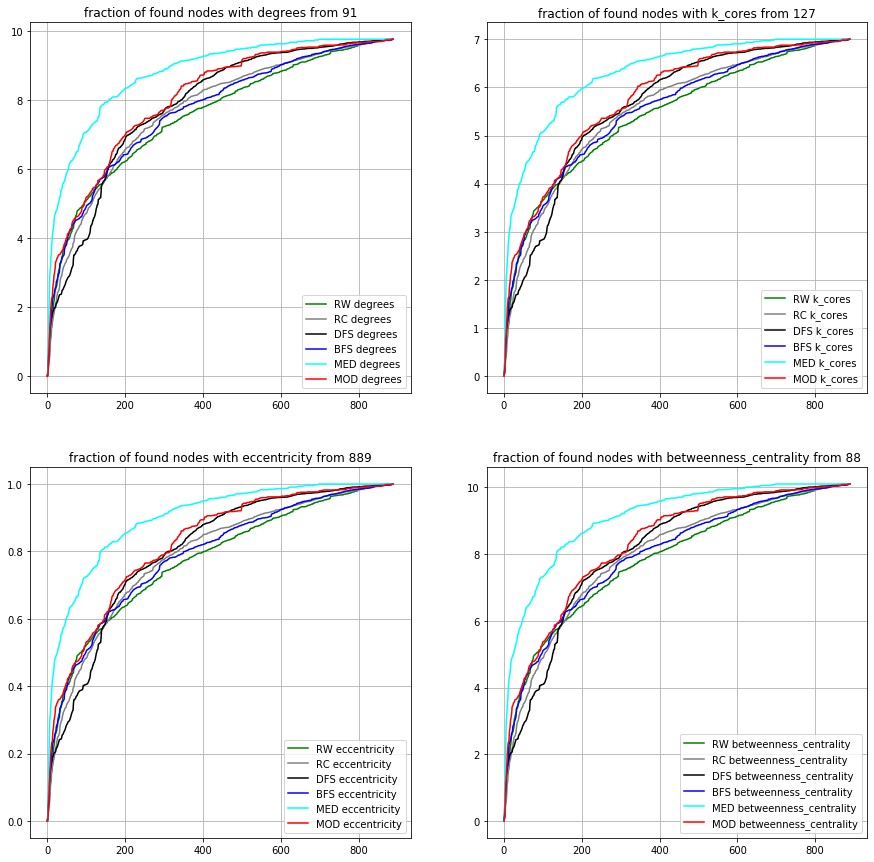

<Figure size 2160x2160 with 0 Axes>

In [6]:
fig,axs = plt.subplots(2,2,figsize=(15,15))
plt.figure(figsize=(30,30))

for prop in metrics_list:
    j = {'degrees':0,'k_cores':1,'eccentricity':2,'betweenness_centrality':3}[prop] 
   # plt.plot([max([method_history[method][prop] for method in methods])/real_seed_count+1]*b, color = 'yellow')
    for method in methods:
    #for start in range(1,method_counter+1):
     #   print('from',total//10*(start-1)-1, 'to',total//10*start-1)    #[total//10*(start-1):total//10*start]
        axs[(j)//2][j%2].plot([i/seed_count/len(percentile_set[prop]) for i in crawler_avg[method][prop]], label =method+' '+prop, color = method_color[method] )
        axs[(j)//2][j%2].set_title('fraction of found nodes with '+prop+ ' from '+str(len(percentile_set[prop])))
        axs[(j)//2][j%2].legend()

    axs[(j)//2][j%2].grid(True)
fig.savefig('../results/'+graph_name+'_scores_'+str(seed_count) +'_seeds_'+str(b)+'iterations.png')

In [7]:
vkprint('i have done everything!!!!')

 i have done everything!!!!


1584